In [45]:
pip install graphviz

In [55]:
from collections import defaultdict
import graphviz
class Grammar:
    def __init__(self):
        # Simple Vietnamese grammar rules
        self.rules = {
            'S': [['NP', 'VP']],
            'NP': [['DET', 'N'], ['N'], ['NP', 'PP']],
            'VP': [['V', 'NP'], ['V']],
            'PP': [['P', 'NP']],
            'DET': ['một', 'cái', 'những'],
            'N': ['tôi', 'cô gái', 'chàng trai', 'quả táo', 'bóng đá', 'sách'],
            'V': ['ăn', 'đọc', 'yêu', 'chơi'],
            'P': ['với', 'trong', 'bằng'],
        }

    def is_nonterminal(self, symbol):
        return symbol in self.rules and isinstance(self.rules[symbol], list)

    def productions(self, nonterminal):
        return self.rules.get(nonterminal, [])

# === NGỮ PHÁP TIẾNG VIỆT MỞ RỘNG ===

VN_GRAMMAR = {
    "S": [["NP", "VP"]],

    # Noun phrases
    "NP": [["Pro"], ["N"], ["Det", "N"], ["N", "N"], ["NP", "PP"]], # Added NP PP rule

    # Verb phrases
    "VP": [["V"], ["V", "NP"], ["V", "Adj"], ["V", "PP"], ["Adv", "V"], ["V", "V"], ["V", "Adv"]], # Added V Adv rule

    # Prepositional phrases
    "PP": [["P", "NP"]],

    # Pronouns
    "Pro": [["Tôi"], ["Em"], ["Anh"], ["Chị"], ["Bạn"], ["Bố"], ["Mẹ"], ["Bé"], ["Con"]], # Removed Ông, Bà as they might be part of "Ông bà"

    # Nouns
    "N": [
        ["cơm"], ["bài"], ["chợ"], ["sách"], ["Hà Nội"], ["cà phê"], ["phim"],
        ["mèo"], ["chó"], ["cờ"], ["tranh"], ["búp bê"], ["nước"], ["báo"], ["mì"],
        ["xe"], ["bánh"], ["nhạc"], ["thư"], ["cây"], ["đồ"], ["tivi"], ["truyện"],
        ["sữa"], ["Toán"], ["tiếng Anh"], ["đồng hồ"], ["ảnh"], ["phòng"], ["hoa"],
        ["đàn"], ["bộ"], ["chén"], ["trưa"], ["dạo"], ["điện"], ["ăn"], ["học"], ["làm"],
        ["việc"], ["Ông bà"], ["bà"], ["tôi"] # Added "Ông bà", "bà", "tôi" as N because they function as nouns in the failed sentences
    ],

    # Determiners
    "Det": [["Con"], ["Ông"]],

    # Verbs
    "V": [
        ["ăn"], ["học"], ["đi"], ["đọc"], ["nấu"], ["yêu"], ["thích"], ["xem"],
        ["ngủ"], ["sủa"], ["chơi"], ["uống"], ["chạy"], ["sửa"], ["làm"], ["nghe"],
        ["mua"], ["viết"], ["tưới"], ["giặt"], ["ngồi"], ["gọi"], ["chờ"], ["rửa"],
        ["dọn"], ["chụp"], ["thăm"], ["lái"], ["làm việc"], ["hát"], ["vẽ"],
        ["chăm"], ["dạo"]
    ],

    # Adjectives
    "Adj": [["nhanh"], ["trưa"]],

    # Adverbs
    "Adv": [["đi"], ["bộ"]],

    # Prepositions
    "P": []
}

# === TRẠNG THÁI CHART PARSER ===
class State:
    def __init__(self, lhs, rhs, dot, start, end):
        self.lhs = lhs
        self.rhs = rhs
        self.dot = dot
        self.start = start
        self.end = end

    def next_symbol(self):
        return self.rhs[self.dot] if self.dot < len(self.rhs) else None

    def is_complete(self):
        return self.dot >= len(self.rhs)

    def advance(self):
        return State(self.lhs, self.rhs, self.dot + 1, self.start, self.end)

    def __eq__(self, other):
        return (self.lhs, self.rhs, self.dot, self.start, self.end) == \
               (other.lhs, other.rhs, other.dot, other.start, other.end)

    def __hash__(self):
        return hash((self.lhs, tuple(self.rhs), self.dot, self.start, self.end))

    def __repr__(self):
        before_dot = ' '.join(self.rhs[:self.dot])
        after_dot = ' '.join(self.rhs[self.dot:])
        return f"[{self.start}:{self.end}] {self.lhs} → {before_dot} • {after_dot}"

# === HÀM PHÂN TÍCH CÚ PHÁP ===
def parse_vietnamese(sentence, grammar=VN_GRAMMAR):
    words = sentence.strip().split()
    n = len(words)
    chart = [set() for _ in range(n + 1)]

    for rhs in grammar["S"]:
        chart[0].add(State("S", rhs, 0, 0, 0))

    for i in range(n + 1):
        added = True
        while added:
            added = False
            states = list(chart[i])
            for state in states:
                next_sym = state.next_symbol()

                if next_sym in grammar:
                    for prod in grammar[next_sym]:
                        new_state = State(next_sym, prod, 0, i, i)
                        if new_state not in chart[i]:
                            chart[i].add(new_state)
                            added = True

                # Modified section to handle multi-word terminals
                elif next_sym is not None and next_sym not in grammar: # It's a terminal symbol
                    # Check if the terminal symbol matches a sequence of words starting at i
                    terminal_words = next_sym.split()
                    terminal_len = len(terminal_words)
                    if i + terminal_len <= n and words[i : i + terminal_len] == terminal_words:
                        new_state = State(state.lhs, state.rhs, state.dot + 1, state.start, i + terminal_len)
                        if new_state not in chart[i + terminal_len]:
                            chart[i + terminal_len].add(new_state)
                            added = True
                # End of modified section

                elif state.is_complete():
                    for st in chart[state.start]:
                        if st.next_symbol() == state.lhs:
                            new_state = State(st.lhs, st.rhs, st.dot + 1, st.start, i)
                            if new_state not in chart[i]:
                                chart[i].add(new_state)
                                added = True

    # Kiểm tra kết quả
    success = False
    for state in chart[n]:
        if state.lhs == "S" and state.start == 0 and state.end == n and state.is_complete():
            success = True
            break

    return success, chart

# === 50 CÂU TIẾNG VIỆT ===
sentences = [
    "Tôi ăn cơm", "Em học bài", "Chị đi chợ", "Bố đọc sách", "Mẹ nấu ăn",
    "Tôi yêu Hà Nội", "Anh thích cà phê", "Bạn xem phim", "Con mèo ngủ",
    "Con chó sủa", "Ông bà chơi cờ", "Tôi hát", "Em vẽ tranh", "Bé chơi búp bê",
    "Tôi uống nước", "Anh đọc báo", "Em chạy nhanh", "Chị nấu mì", "Bố sửa xe",
    "Mẹ làm bánh", "Tôi nghe nhạc", "Bạn làm bài", "Anh đi học", "Em mua sách",
    "Chị chơi đàn", "Tôi đi bộ", "Anh rửa chén", "Em viết thư", "Bố tưới cây",
    "Mẹ giặt đồ", "Tôi ngủ trưa", "Em xem tivi", "Chị đi xe", "Anh học Toán",
    "Tôi đi làm", "Bạn học tiếng Anh", "Em đọc truyện", "Anh uống sữa",
    "Chị thăm bà", "Tôi đi dạo", "Bạn ngồi học", "Mẹ gọi tôi", "Em xem đồng hồ",
    "Tôi chờ xe", "Anh lái xe", "Chị làm việc", "Bạn gọi điện", "Tôi chụp ảnh",
    "Em dọn phòng", "Chị chăm hoa"
]

# === CHẠY PARSER CHO 50 CÂU ===
print("=== KIỂM TRA 50 CÂU TIẾNG VIỆT ===\n")
passed = 0
failed_sentences = []

for s in sentences:
    success, _ = parse_vietnamese(s)
    if success:
        print(f"THÀNH CÔNG: \"{s}\"")
        passed += 1
    else:
        print(f"THẤT BẠI: \"{s}\"")
        failed_sentences.append(s)

print(f"\nĐã phân tích thành công: {passed}/{len(sentences)} câu")

if failed_sentences:
    print("\n=== CÁC CÂU CHƯA PHÂN TÍCH ĐƯỢC ===")
    for s in failed_sentences:
        print(f"- \"{s}\"")

# === PHÂN TÍCH CÂU KHÓ ===
def analyze_sentence(sentence):
    """Phân tích chi tiết câu và hiển thị trạng thái phân tích"""
    print(f"\n=== PHÂN TÍCH CHI TIẾT: \"{sentence}\" ===")
    words = sentence.strip().split()
    success, chart = parse_vietnamese(sentence)

    for i, states in enumerate(chart):
        print(f"\nCHART[{i}]:")
        for state in sorted(states, key=lambda s: (s.start, s.lhs)):
            print(f"  {state}")

    if success:
        print(f"\nTHÀNH CÔNG: Câu \"{sentence}\" được phân tích thành công")
    else:
        print(f"\nTHẤT BẠI: Câu \"{sentence}\" không thể phân tích")

# Phân tích một số câu khó
#problem_sentences = ["Ông bà chơi cờ", "Mẹ nấu ăn", "Tôi đi bộ", "Tôi đi làm"]
#for sentence in problem_sentences:
#    analyze_sentence(sentence)

=== KIỂM TRA 50 CÂU TIẾNG VIỆT ===

THÀNH CÔNG: "Tôi ăn cơm"
THÀNH CÔNG: "Em học bài"
THÀNH CÔNG: "Chị đi chợ"
THÀNH CÔNG: "Bố đọc sách"
THÀNH CÔNG: "Mẹ nấu ăn"
THÀNH CÔNG: "Tôi yêu Hà Nội"
THÀNH CÔNG: "Anh thích cà phê"
THÀNH CÔNG: "Bạn xem phim"
THÀNH CÔNG: "Con mèo ngủ"
THÀNH CÔNG: "Con chó sủa"
THÀNH CÔNG: "Ông bà chơi cờ"
THÀNH CÔNG: "Tôi hát"
THÀNH CÔNG: "Em vẽ tranh"
THÀNH CÔNG: "Bé chơi búp bê"
THÀNH CÔNG: "Tôi uống nước"
THÀNH CÔNG: "Anh đọc báo"
THÀNH CÔNG: "Em chạy nhanh"
THÀNH CÔNG: "Chị nấu mì"
THÀNH CÔNG: "Bố sửa xe"
THÀNH CÔNG: "Mẹ làm bánh"
THÀNH CÔNG: "Tôi nghe nhạc"
THÀNH CÔNG: "Bạn làm bài"
THÀNH CÔNG: "Anh đi học"
THÀNH CÔNG: "Em mua sách"
THÀNH CÔNG: "Chị chơi đàn"
THÀNH CÔNG: "Tôi đi bộ"
THÀNH CÔNG: "Anh rửa chén"
THÀNH CÔNG: "Em viết thư"
THÀNH CÔNG: "Bố tưới cây"
THÀNH CÔNG: "Mẹ giặt đồ"
THÀNH CÔNG: "Tôi ngủ trưa"
THÀNH CÔNG: "Em xem tivi"
THÀNH CÔNG: "Chị đi xe"
THÀNH CÔNG: "Anh học Toán"
THÀNH CÔNG: "Tôi đi làm"
THÀNH CÔNG: "Bạn học tiếng Anh"
THÀNH CÔNG: "Em 

In [46]:
# Phân tích một số câu khó
problem_sentences = ["Ông bà chơi cờ", "Mẹ nấu ăn", "Tôi đi bộ", "Tôi đi làm"]
problem_sentences = ["Tôi đi làm"]
for sentence in problem_sentences:
    analyze_sentence(sentence)


=== PHÂN TÍCH CHI TIẾT: "Tôi đi làm" ===

CHART[0]:
  [0:0] Det →  • Con
  [0:0] Det →  • Ông
  [0:0] N →  • bánh
  [0:0] N →  • nước
  [0:0] N →  • cờ
  [0:0] N →  • đồng hồ
  [0:0] N →  • tranh
  [0:0] N →  • bộ
  [0:0] N →  • Ông bà
  [0:0] N →  • sữa
  [0:0] N →  • búp bê
  [0:0] N →  • học
  [0:0] N →  • chó
  [0:0] N →  • hoa
  [0:0] N →  • bà
  [0:0] N →  • phòng
  [0:0] N →  • xe
  [0:0] N →  • đồ
  [0:0] N →  • tôi
  [0:0] N →  • sách
  [0:0] N →  • mèo
  [0:0] N →  • truyện
  [0:0] N →  • ảnh
  [0:0] N →  • bài
  [0:0] N →  • cây
  [0:0] N →  • việc
  [0:0] N →  • báo
  [0:0] N →  • chén
  [0:0] N →  • chợ
  [0:0] N →  • dạo
  [0:0] N →  • tivi
  [0:0] N →  • điện
  [0:0] N →  • tiếng Anh
  [0:0] N →  • thư
  [0:0] N →  • ăn
  [0:0] N →  • cơm
  [0:0] N →  • làm
  [0:0] N →  • nhạc
  [0:0] N →  • mì
  [0:0] N →  • đàn
  [0:0] N →  • phim
  [0:0] N →  • cà phê
  [0:0] N →  • trưa
  [0:0] N →  • Hà Nội
  [0:0] N →  • Toán
  [0:0] NP →  • Pro
  [0:0] NP →  • NP PP
  [0:0] NP → 

In [47]:
# Example usage:
if __name__ == "__main__":
    # Visualize the grammar
    #visualize_grammar(VN_GRAMMAR)

    # Test the parser with a sentence and visualize the parse tree
    test_sentence = "Tôi ăn cơm"
    success, chart = parse_vietnamese(test_sentence)
    #if success:
    #    visualize_parse_tree(chart, test_sentence)

    # Analyze grammar coverage
    #analyze_grammar_coverage(VN_GRAMMAR, sentences)

    # Interactive exploration
    #interactive_grammar_explorer(VN_GRAMMAR)

In [48]:
def print_grammar_structure(grammar):
    """
    Print a structural representation of the grammar with indentation.

    Args:
        grammar (dict): The grammar dictionary with rules
    """
    print("\n=== VIETNAMESE GRAMMAR STRUCTURE ===\n")

    def explore_symbol(symbol, visited=None, depth=0, path=None):
        if visited is None:
            visited = set()
        if path is None:
            path = []

        # Check for circular references to avoid infinite recursion
        if symbol in path:
            print("  " * depth + f"{symbol} [CIRCULAR REFERENCE]")
            return

        # Print the current symbol
        print("  " * depth + f"{symbol}")

        # If it's a non-terminal, explore its productions
        if symbol in grammar and symbol not in visited:
            visited.add(symbol)
            path.append(symbol)

            for production in grammar[symbol]:
                if isinstance(production, list):
                    print("  " * (depth + 1) + f"→ {' '.join(production)}")
                    for subsymbol in production:
                        explore_symbol(subsymbol, visited, depth + 2, path.copy())
                else:
                    print("  " * (depth + 1) + f"→ \"{production}\"")

            path.pop()

    # Start exploration from the 'S' symbol (sentence)
    explore_symbol('S')

In [49]:
print_grammar_structure(VN_GRAMMAR)


=== VIETNAMESE GRAMMAR STRUCTURE ===

S
  → NP VP
    NP
      → Pro
        Pro
          → Tôi
            Tôi
          → Em
            Em
          → Anh
            Anh
          → Chị
            Chị
          → Bạn
            Bạn
          → Bố
            Bố
          → Mẹ
            Mẹ
          → Bé
            Bé
          → Con
            Con
      → N
        N
          → cơm
            cơm
          → bài
            bài
          → chợ
            chợ
          → sách
            sách
          → Hà Nội
            Hà Nội
          → cà phê
            cà phê
          → phim
            phim
          → mèo
            mèo
          → chó
            chó
          → cờ
            cờ
          → tranh
            tranh
          → búp bê
            búp bê
          → nước
            nước
          → báo
            báo
          → mì
            mì
          → xe
            xe
          → bánh
            bánh
          → nhạc
            nhạc
          → thư


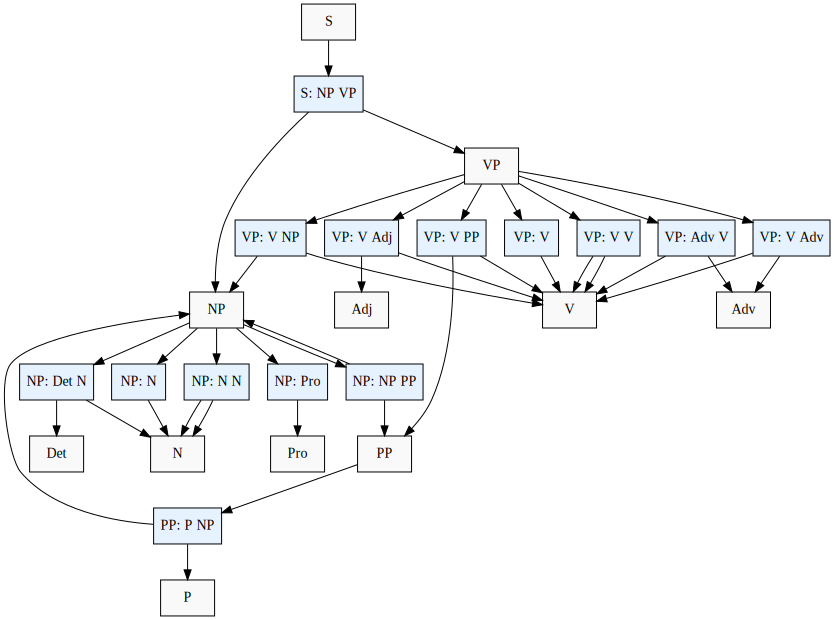

In [59]:
def visualize_grammar_tree_graphviz(grammar, show_terminals=False):
    """
    Tạo biểu đồ cây cú pháp sử dụng Graphviz

    Args:
        grammar: Từ điển chứa các luật ngữ pháp
        show_terminals: Có hiển thị các từ kết thúc (terminal words) hay không

    Returns:
        Đối tượng Graphviz Digraph
    """
    # Tạo đối tượng Digraph
    dot = graphviz.Digraph(comment='Grammar Tree')
    dot.attr('node', shape='box', style='filled', fillcolor='#f9f9f9')

    node_count = 0
    node_map = {}  # Lưu ánh xạ giữa non-terminal và ID node

    # Tạo những nút gốc cho các loại cấu trúc ngữ pháp
    for symbol in grammar:
        node_id = f"{symbol}_{node_count}"
        node_map[symbol] = node_id
        dot.node(node_id, symbol)
        node_count += 1

    # Xử lý các luật mở rộng cho mỗi ký hiệu phi kết thúc (non-terminal)
    for symbol, expansions in grammar.items():
        parent_node = node_map[symbol]  # Lấy nút gốc cho ký hiệu

        # Xử lý mỗi luật mở rộng
        for i, expansion in enumerate(expansions):
            # Kiểm tra xem expansion có chứa terminal nodes không
            contains_only_terminals = all(comp not in grammar for comp in expansion)

            # Nếu chỉ chứa terminals và không hiển thị terminals, thì bỏ qua
            if contains_only_terminals and not show_terminals:
                continue

            # Tạo một nút mở rộng cho mỗi luật - bỏ qua các terminal words nếu show_terminals=False
            if show_terminals:
                expansion_label = f"{symbol}: {' '.join(expansion)}"
            else:
                # Chỉ hiển thị các non-terminals trong expansion
                non_terminal_parts = [comp for comp in expansion if comp in grammar]
                if non_terminal_parts:  # Chỉ hiển thị nếu có non-terminals
                    expansion_label = f"{symbol}: {' '.join(non_terminal_parts)}"
                else:
                    # Nếu expansion chỉ chứa terminals, hiển thị tên symbol để người dùng biết luật tồn tại
                    expansion_label = f"{symbol}: ..."

            expansion_id = f"{symbol}_exp_{i}"
            dot.node(expansion_id, expansion_label, fillcolor='#e6f3ff')
            dot.edge(parent_node, expansion_id)

            # Xử lý từng thành phần trong luật mở rộng
            for j, component in enumerate(expansion):
                # Chỉ xử lý các non-terminals
                if component in grammar:
                    # Kết nối đến nút gốc của nó
                    child_node = node_map[component]
                    dot.edge(expansion_id, child_node)
                elif show_terminals:  # Chỉ hiển thị terminals khi show_terminals=True
                    terminal_id = f"term_{node_count}"
                    dot.node(terminal_id, component, fillcolor='#f0e6ff')
                    dot.edge(expansion_id, terminal_id)
                    node_count += 1

    return dot

# Tạo biểu đồ cây cú pháp (không hiển thị các từ kết thúc)
graph = visualize_grammar_tree_graphviz(VN_GRAMMAR, show_terminals=False)

# Hiển thị biểu đồ trong Colab
graph